# Using `jatic_toolbox`'s Object Detection Protocol with `xaitk-saliency`

This is a simple notebook demonstrating how detectors based on `jatic_toolbox`'s object detection protocol can interface with `xaitk-saliency`.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Example Image](#example-image)
* [Instantiate Protocol-Based Detector](#instantiate-protocol-based-detector)
* [Transform Protocol-Based Detector](#transform-protocol-based-detector)
* [Use the Detector as "Normal"](#use-detector-as-normal)
    * [Get Detections](#get-detections)
    * [Generate Saliency Maps](#generate-saliency-maps)
        * [Prepare Inputs](#prepare-inputs)
        * [Saliency Generation](#saliency-generation)
        * [Display Saliency Maps](#display-saliency-maps)
    

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing xaitk-cdao...")
!{sys.executable} -m pip install -q ../..
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing smqtk-detection...")
!{sys.executable} -m pip install -qU smqtk-detection[centernet]
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip -q install torchvision
print("Installing tqdm...")
!{sys.executable} -m pip -q install tqdm
print("Installing hydra-zen...")
!{sys.executable} -m pip -q install hydra-zen
print("Installing pooch...")
!{sys.executable} -m pip -q install pooch
print("Done!")

Installing xaitk-cdao...
Installing xaitk-saliency...
Installing smqtk-detection...
Installing headless OpenCV...
Installing torch...
Installing torchvision...
Installing tqdm...
Installing hydra-zen...
Installing pooch...
Done!


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt  # type: ignore
from matplotlib.patches import Rectangle  # type: ignore

import numpy as np
import os
import time
import urllib.request
from PIL import Image

from jatic_toolbox.interop.smqtk import CenterNet

from xaitk_cdao.interop.jatic_toolbox.object_detection import JATICDetector
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import RandomGridStack

## Example Image <a name="example-image"></a>

We'll use a single example image from the VisDrone test dataset.

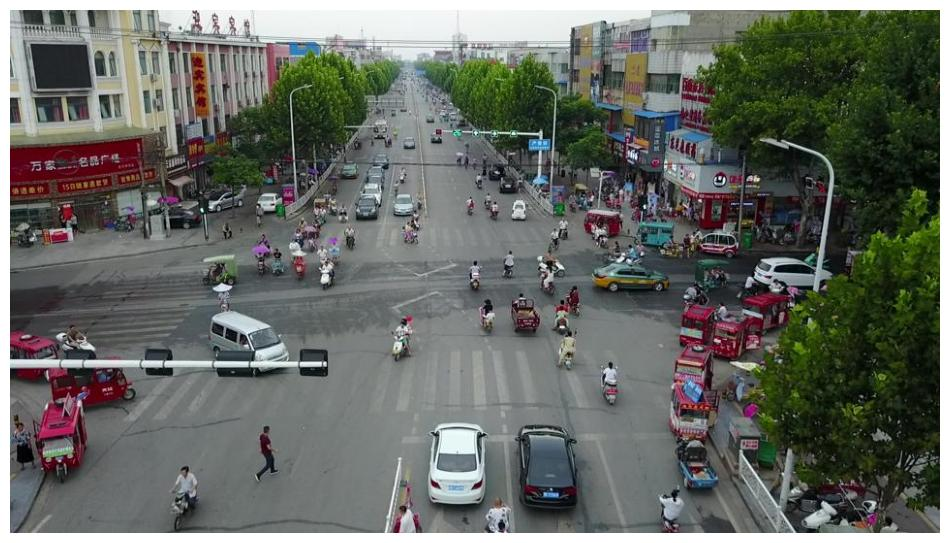

In [3]:
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

data_dir = './data'
url = 'https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download'

os.makedirs(data_dir, exist_ok=True)

img_path = os.path.join(data_dir, 'visdrone_img.jpg')
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)
    
img = np.asarray(Image.open(img_path))

plt.figure(figsize=(12,12))
plt.axis('off')
_ = plt.imshow(img)

We'll also define a function to display detections:

In [4]:
def show_dets(ax, dets, thresh=0.5, show_labels=False):
    for i, det in enumerate(dets):
        score_dict = det[1]
        cls_name = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_name]
        
        if conf >= thresh:
            bbox = det[0]
            x1, y1 = bbox.min_vertex
            x2, y2 = bbox.max_vertex
            ax.add_patch(Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            ))

            if show_labels:
                label=f'{cls_name} {conf:.2f}'
                ax.text(x1, y1 - 2, label, color='b', fontsize=8)

## Instantiate Protocol-Based Detector <a name="instantiate-protocol-based-detector"></a>

First, we need a detector that uses the object detection protocol. Here we'll be using a configuration for SMQTK CenterNet. This doesn't really make sense in terms of real-world application as we'll be going from a SMQTK detector to a JATIC toolbox detector and back again, but the point of this notebook is to demonstrate the actual mechanics of the process.

In [5]:
jatic_detector = CenterNet.from_pretrained("resnet50")

## Transform Protocol-Based Detector <a name="transform-protocol-based-detector"></a>

Now that we have our protocol-based detector, we can wrap it so that it can be used directly with `xaitk-saliency`.

In [6]:
detector = JATICDetector(jatic_detector)

## Use the Detector as "Normal" <a name="use-detector-as-normal"></a>

Now the detector can be used just like it is a regular `DetectImageObjects` implementation with `xaitk-saliency`.

### Get Detections <a name="get-detections"></a>

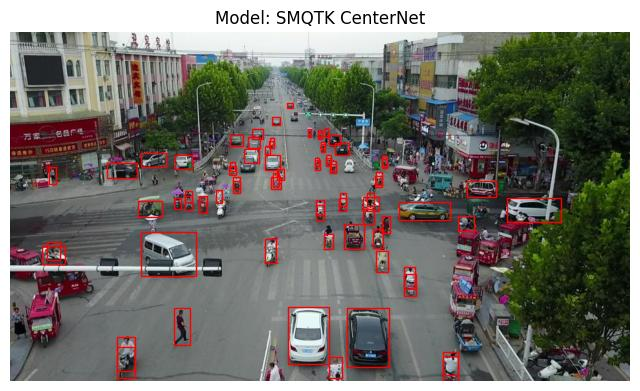

In [7]:
dets = list(detector([img]))[0]

# Display detections
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Model: SMQTK CenterNet")
axs.imshow(img)
axs.axis("off")
show_dets(axs, dets, thresh=0.4)

### Generate Saliency Maps <a name="generate-saliency-maps"></a>

For the sake of this example, we have pre-selected four reference detections from the predictions made by the model to compute saliency maps. These are displayed below.

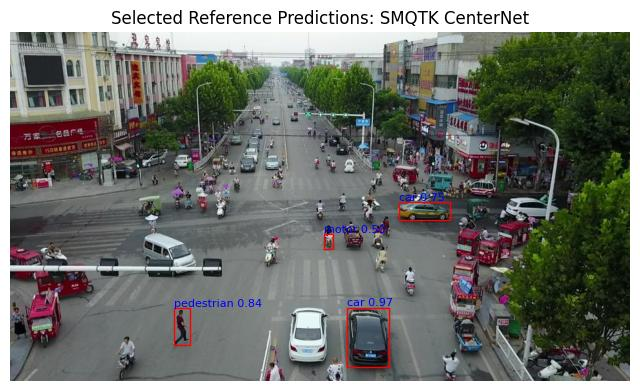

In [8]:
# indices of reference detections
centernet_idxs = [2, 0, 33, 3]
centernet_ref_dets = [list(dets)[idx] for idx in centernet_idxs]

fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title("Selected Reference Predictions: SMQTK CenterNet")
axs.imshow(img)
axs.axis("off")
show_dets(axs, centernet_ref_dets, thresh=0.4, show_labels=True)

#### Prepare Inputs <a name="prepare-inputs"></a>

The `GenerateObjectDetectorBlackboxSaliency` interface requires our reference detections to be split into separate bounding boxes and scores inputs, both as numpy arrays.

In [9]:
def dets_to_mats(dets):
    
    # use labels from first prediction to access all of them in a constant order
    labels = list(dets[0][1].keys())
    
    bboxes = np.empty((0, 4))
    scores = np.empty((0, 10))
    for det in dets:
        bbox = det[0]
        
        bboxes = np.vstack((
            bboxes,
            [*bbox.min_vertex, *bbox.max_vertex,]
        ))

        score_dict = det[1]
        score_array = []
        for l in labels:
            score_array.append(score_dict[l])
            
        scores = np.vstack((
            scores,
            score_array,
        ))
    
    return bboxes, scores

centernet_bboxes, centernet_scores = dets_to_mats(centernet_ref_dets)

#### Saliency Generation <a name="saliency-generation"></a>

We'll use the `RandomGridStack` implementation to generate our saliency maps.

In [10]:
sal_generator = RandomGridStack(
    n=150,  # number of masks
    s=(7,7),  # occlusion grid cell size in pixels
    p1=0.7,  # probability of not occluding cell
    threads=8,  # execution threads
    seed=42,  # seed for replicable results
)

# gray average of VisDrone
fill = [95, 96, 93]
sal_generator.fill = fill

In [11]:
print("Generating CenterNet saliency maps...")
start = time.time()
centernet_sal_maps = sal_generator(
    img,
    centernet_bboxes,
    centernet_scores,
    detector
)
end = time.time()
print(f"Done in {end-start:.2f}s")

Generating CenterNet saliency maps...
Done in 199.14s


#### Display Saliency Maps <a name="display-saliency-maps"></a>

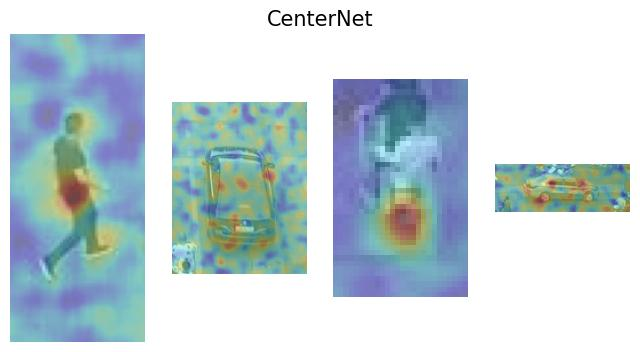

In [12]:
gray_img = np.asarray(Image.fromarray(img).convert("L"))
pad_perc = 0.4

n = len(centernet_sal_maps)

fig, axs = plt.subplots(1, n, figsize=(8,4))

for i, ax in enumerate(axs):

        try:
            sal_map = centernet_sal_maps[i]
        except IndexError:
            ax.axis('off')
            continue

        x1, y1, x2, y2 = centernet_bboxes[i]
        pad_x = pad_perc * (x2 - x1)
        pad_y = pad_perc * (y2 - y1)
        x1 = max(int(x1 - pad_x),0)
        y1 = max(int(y1 - pad_y), 0)
        x2 = int(x2 + pad_x)
        y2 = int(y2 + pad_y)

        img_crop = gray_img[y1:(y2+1), x1:(x2+1)]
        sal_crop = sal_map[y1:(y2+1), x1:(x2+1)]

        ax.imshow(img_crop, alpha=0.7, cmap='gray')
        ax.imshow(sal_crop, alpha=0.3, cmap='jet')
        ax.axis('off')
        
axs = fig.subplots()
axs.set_title("CenterNet", fontsize=15)
_ = axs.axis('off')